# Dreamer V3 imagination  + reconstruct observations

This notebook is updated to SheepRL version [v0.5.4](https://github.com/Eclectic-Sheep/sheeprl/tree/release/v0.5.4). It provides a way to obtain the imagined and reconstructed frames of the Dreamer V3 agent. By default, a GIF is created, but one can create a video from them.

This notebook is organized as follows:
1. Agent and environment creation from checkpoint
2. Buffer initialization: the buffers necessary for saving collected experiences, imagined and reconstructed observations.
3. Initial environment interaction: the agent plays a number of `initial_steps` in the environment. The collected steps are saved in the `rb_initial` buffer.
4. Imagination and reconstruction: we set `imagination_steps` as the number of imagination/reconstruction steps we want the agent to perform. So the agent starts from the $\texttt{initial\_step} - \texttt{imagination\_steps}$ step and the imagined/reconstructed observations are computed for the steps in $[\texttt{initial\_step} - \texttt{imagination\_steps}, \texttt{initial\_step}]$.
5. GIF Creation.

In [19]:
import copy
import pathlib
import tempfile

import gymnasium as gym
import numpy as np
import torch
from lightning.fabric import Fabric
from omegaconf import OmegaConf

from sheeprl.algos.dreamer_v3.agent import build_agent
from sheeprl.data.buffers import SequentialReplayBuffer
from sheeprl.utils.env import make_env
from sheeprl.utils.utils import dotdict

import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download

def _d(file):
    return hf_hub_download(
        repo_id='ML2/meent-sample-data', 
        filename=file, 
        repo_type='dataset',
    )

## Download pretrained agent(This takes a while)

In [ ]:
ckpt_path = _d('dv3/version_0/checkpoint/ckpt_216000_0.ckpt')
config_path = _d('dv3/version_0/config.yaml')

ckpt_216000_0.ckpt:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

## Agent and Environment initialization

The checkpoint is taken and the number of environments is set to 1 since we want to observe the ability of the agent to reconstruct the observations or to imagine future steps.

The code for creating the environment and initializing the agent is the same of the `sheeprl/algos/dreamer_v3/dreamer_v3.py` file.

In [11]:
base_dir = 'sample'
# path of your checkpoint
# ckpt_path = pathlib.Path(f"{base_dir}/version_0/checkpoint/ckpt_216000_0.ckpt")
# seed = 42 # + 3
fabric = Fabric(accelerator="cuda", devices=1)
state = fabric.load(ckpt_path)
cfg = OmegaConf.load(f'{base_dir}/version_0/config.yaml')
cfg = OmegaConf.to_container(cfg, resolve=True)
cfg = dotdict(cfg)

# The number of environments is set to 1
cfg.env.num_envs = 1

In [12]:
cfg.env.max_episode_steps = 9999999

In [13]:
envs = gym.vector.AsyncVectorEnv(
    [
        make_env(
            cfg,
            cfg.seed + 0 * cfg.env.num_envs + i,
            0 * cfg.env.num_envs,
            "./imagination",
            "imagination",
            vector_env_idx=i,
        ) for i in range(cfg.env.num_envs)
    ]
)
action_space = envs.single_action_space
observation_space = envs.single_observation_space
obs_keys = cfg.algo.cnn_keys.encoder + cfg.algo.mlp_keys.encoder

In [14]:
torch.set_float32_matmul_precision('high')
is_continuous = isinstance(action_space, gym.spaces.Box)
is_multidiscrete = isinstance(action_space, gym.spaces.MultiDiscrete)
actions_dim = tuple(
    action_space.shape if is_continuous else (action_space.nvec.tolist() if is_multidiscrete else [action_space.n])
)
world_model, actor, critic, critic_target, player = build_agent(
    fabric,
    actions_dim,
    is_continuous,
    cfg,
    observation_space,
    state["world_model"],
    state["actor"],
    state["critic"],
    state["target_critic"],
)

## Buffer initialization

Here, buffers are initialized where the steps played by the agent will be saved:
- `rb_initial`: used to save the steps played during the initial environment interaction. (dimension equal to `intial_steps`).
- `rb_play`: contains the reconstructed observations of dimension `imagination_steps`.
- `rb_imagination`: contains the imagined steps. 

The reconstructed and the imagined steps are from the $\texttt{initial\_step} - \texttt{imagination\_steps}$ step to the $\texttt{initial\_step}$ step.

Tips:
- If you want to observe how the agent behaves in the first steps of the episode, set the value of `initial_steps` low.
- The `imagination_steps` should not be too high, since during training the agent imagines 15 steps ahead.
- If you are not interested in the imagination part, then you can set `initial_steps` equal to `imagination_steps`.

In [19]:
initial_steps = 30  # set according to your environment.
imagination_steps = 25 # number of imagination steps, must be lower than or equal to the `initial_steps`.

In [20]:
clip_rewards_fn = lambda r: torch.tanh(r) if cfg.env.clip_rewards else r
rb_initial = SequentialReplayBuffer(initial_steps, cfg.env.num_envs)
rb_play = SequentialReplayBuffer(initial_steps, cfg.env.num_envs)
rb_imagination = SequentialReplayBuffer(imagination_steps, cfg.env.num_envs)
step_data = {}
player.init_states()
obs = envs.reset(seed=cfg.seed)[0]
for k in obs_keys:
    step_data[k] = obs[k][np.newaxis]
step_data["dones"] = np.zeros((1, cfg.env.num_envs, 1))
step_data["rewards"] = np.zeros((1, cfg.env.num_envs, 1))
step_data["is_first"] = np.ones_like(step_data["dones"])
step_data["stochastic_state"] = player.stochastic_state.detach().cpu().numpy()
step_data["recurrent_state"] = player.recurrent_state.detach().cpu().numpy()

{'max_eff': 0.0}


## Environment interaction

The agent plays for `initial_steps` and save the collected steps into the `rb_initial` buffer. Latent states computed by the agent during this phase are saved. The Observations are then reconstructed from them.

In [23]:
info_list = []
# play for `initial_steps` steps
for i in range(initial_steps):
    print(f"{i} step: max. eff. {envs.get_attr('max_eff')[0]}")
    
    with torch.no_grad():
        preprocessed_obs = {}
        for k, v in obs.items():
            preprocessed_obs[k] = torch.as_tensor(v[np.newaxis], dtype=torch.float32, device=fabric.device)
            if k in cfg.algo.cnn_keys.encoder:
                preprocessed_obs[k] = preprocessed_obs[k] / 255.0 - 0.5
        mask = {k: v for k, v in preprocessed_obs.items() if k.startswith("mask")}
        if len(mask) == 0:
            mask = None
        real_actions = actions = player.get_actions(preprocessed_obs, mask=mask)
        actions = torch.cat(actions, -1).cpu().numpy()
        if is_continuous:
            real_actions = torch.cat(real_actions, dim=-1).cpu().numpy()
        else:
            real_actions = torch.cat([real_act.argmax(dim=-1) for real_act in real_actions], dim=-1).cpu().numpy()

    step_data["actions"] = actions.reshape((1, cfg.env.num_envs, -1))
    rb_initial.add(step_data, validate_args=cfg.buffer.validate_args)

    next_obs, rewards, dones, truncated, infos = envs.step(real_actions.reshape(envs.action_space.shape))
    rewards = np.array(rewards).reshape((1, cfg.env.num_envs, -1))
    dones = np.logical_or(dones, truncated).astype(np.uint8).reshape((1, cfg.env.num_envs, -1))

    step_data["is_first"] = np.zeros_like(step_data["dones"])
    if "restart_on_exception" in infos:
        for i, agent_roe in enumerate(infos["restart_on_exception"]):
            if agent_roe and not dones[i]:
                last_inserted_idx = (rb_initial.buffer[i]._pos - 1) % rb_initial.buffer[i].buffer_size
                rb_initial.buffer[i]["dones"][last_inserted_idx] = np.ones_like(
                    rb_initial.buffer[i]["dones"][last_inserted_idx]
                )
                rb_initial.buffer[i]["is_first"][last_inserted_idx] = np.zeros_like(
                    rb_initial.buffer[i]["is_first"][last_inserted_idx]
                )
                step_data["is_first"][i] = np.ones_like(step_data["is_first"][i])

    real_next_obs = copy.deepcopy(next_obs)
    if "final_observation" in infos:
        for idx, final_obs in enumerate(infos["final_observation"]):
            if final_obs is not None:
                for k, v in final_obs.items():
                    real_next_obs[k][idx] = v

    for k in obs_keys:
        step_data[k] = next_obs[k][np.newaxis]

    obs = next_obs

    rewards = rewards.reshape((1, cfg.env.num_envs, -1))
    step_data["dones"] = dones.reshape((1, cfg.env.num_envs, -1))
    step_data["rewards"] = clip_rewards_fn(rewards)
    step_data["rewards"] = clip_rewards_fn(rewards)
    step_data["stochastic_state"] = player.stochastic_state.detach().cpu().numpy()
    step_data["recurrent_state"] = player.recurrent_state.detach().cpu().numpy()
    dones_idxes = dones.nonzero()[0].tolist()
    reset_envs = len(dones_idxes)
    if reset_envs > 0:
        reset_data = {}
        for k in obs_keys:
            reset_data[k] = (real_next_obs[k][dones_idxes])[np.newaxis]
        reset_data["dones"] = np.ones((1, reset_envs, 1))
        reset_data["actions"] = np.zeros((1, reset_envs, np.sum(actions_dim)))
        reset_data["rewards"] = step_data["rewards"][:, dones_idxes]
        reset_data["is_first"] = np.zeros_like(reset_data["dones"])
        rb_initial.add(reset_data, dones_idxes, validate_args=cfg.buffer.validate_args)

        # Reset already inserted step data
        step_data["rewards"][:, dones_idxes] = np.zeros_like(reset_data["rewards"])
        step_data["dones"][:, dones_idxes] = np.zeros_like(step_data["dones"][:, dones_idxes])
        step_data["is_first"][:, dones_idxes] = np.ones_like(step_data["is_first"][:, dones_idxes])
        player.init_states(dones_idxes)

    ## Save the recurrent and stochastic latent states for the imagination phase
    if i == initial_steps - imagination_steps - 1:
        stochastic_state = player.stochastic_state.view(1, 1, -1).clone()
        recurrent_state = player.recurrent_state.clone()

0 step: (0.0,)
1 step: (0.005908880004586936,)
2 step: (0.018756319000645748,)
3 step: (0.03442981989550087,)
4 step: (0.058402887457634736,)
5 step: (0.11663498893014522,)
6 step: (0.16267718290714972,)
7 step: (0.19890538851307762,)
8 step: (0.2184322649209516,)
9 step: (0.24495559514172616,)
10 step: (0.2719142899947586,)
11 step: (0.30017708430364465,)
12 step: (0.3487602490440192,)
13 step: (0.4008059312253909,)
14 step: (0.4464254965698694,)
15 step: (0.4833947525347492,)
16 step: (0.5259629270994498,)
17 step: (0.5594439800594806,)
18 step: (0.6295521148365779,)
19 step: (0.6778820255734183,)
20 step: (0.6778820255734183,)
21 step: (0.6778820255734183,)
22 step: (0.7508492837454712,)
23 step: (0.7508492837454712,)
24 step: (0.7508492837454712,)
25 step: (0.7508492837454712,)
26 step: (0.7508492837454712,)
27 step: (0.7508492837454712,)
28 step: (0.7508492837454712,)
29 step: (0.7508492837454712,)


## Imagination and Reconstruction

This is where the imagination and reconstruction phase takes place. You can decide whether to sample actions (as during training) or use the actions collected during training.

The reconstructed steps are the same as those imagined, for easier comparison.

In the `rb_imagination` buffer are stored also the actions: you can compare them with the ones in the `rb_intial` to check whether or not the agent takes the same actions it has imagined (this makes sense only if `imagine_actions=True`).

In [24]:
# deciede if you want to take the actions from the buffer
# (i.e., the actions actually played by the agent)
# or imagine them and compare with the actions actually played by the agent
imagine_actions = False

In [25]:
reconstruced_step_data = {}
with torch.no_grad():
    for i in range(initial_steps):        
    # reconstruct the observations from the latent states used when interacting with the environment
        played_latent_states = torch.cat(
            (
                torch.tensor(rb_initial["stochastic_state"][i], device=fabric.device),
                torch.tensor(rb_initial["recurrent_state"][i], device=fabric.device),
            ),
            -1,
        )
        rec_obs_played = world_model.observation_model(played_latent_states)
        # The decoder has been trained to reconstruct the observations from the latent states in the range [-0.5, 0.5]
        # NOTE: Check how the observations are handled in older versions of SheepRL (before 0.5.5)
        # if you need to add 0.5 or not (in latest versions it is done automatically by the decoder in its forward method).
        reconstruced_step_data["real_field"] = rec_obs_played["real_field"].unsqueeze(0).detach().cpu().numpy() + 0.5
        rb_play.add(reconstruced_step_data)

In [26]:
# imagination / reconstruction obs process
imagined_latent_states = torch.cat((stochastic_state, recurrent_state), -1)
step_data = {}
reconstruced_step_data = {}
with torch.no_grad():
    for i in range(imagination_steps):
        if imagine_actions:
            # imagined actions
            actions = actor(imagined_latent_states.detach())[0][0]
        else:
            # actions actually played by the agent
            actions = torch.tensor(
                rb_initial["actions"][-imagination_steps + i - 1],
                device=fabric.device,
                dtype=torch.float32,
            )[None]

        # imagination step
        stochastic_state, recurrent_state = world_model.rssm.imagination(stochastic_state.view(1, 1, -1), recurrent_state, actions)
        stochastic_state = stochastic_state.view(1, 1, -1)
        imagined_latent_states = torch.cat((stochastic_state, recurrent_state), -1)
        # update current state
        rec_obs = world_model.observation_model(imagined_latent_states)
        step_data["real_field"] = rec_obs["real_field"].unsqueeze(0).detach().cpu().numpy() + 0.5
        step_data["actions"] = actions.unsqueeze(0).detach().cpu().numpy()
        rb_imagination.add(step_data)

## Context steps

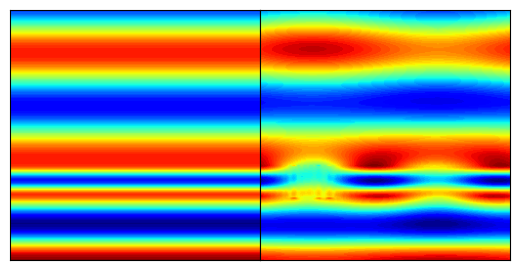

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
ctx = rb_initial["real_field"][:-imagination_steps-1].squeeze() / 255.
ax = axes[0]
ax.imshow(ctx[0], cmap='jet')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
ax.imshow(ctx[-1], cmap='jet')
ax.set_xticks([])
ax.set_yticks([])


plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)


## Dynamics predictions

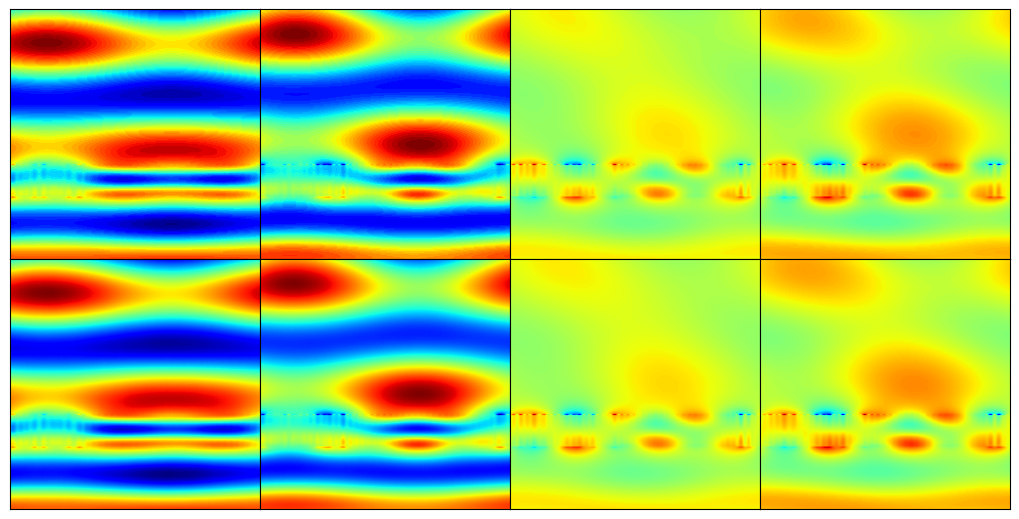

In [33]:
indices = [0, 4, 14, 24]

real_arr = rb_initial["real_field"][-imagination_steps:,].squeeze() / 255.
imag_arr = rb_imagination["real_field"].squeeze()
recon_arr = rb_play["real_field"].squeeze()

fig, axes = plt.subplots(2, len(indices), figsize=(10, 5))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i, j in enumerate(indices):
    ax = axes[0][i]
    ax.imshow(real_arr[j], cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = axes[1][i]
    ax.imshow(imag_arr[j], cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    